In [1]:
%load_ext autoreload
%autoreload 2
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib widget
import rawpy
import numpy as np
import io
from PIL import Image
from io import BytesIO
from IPython.display import display
import matplotlib.pyplot as plt

type: RawType.Flat
pattern: [[2 3]
 [1 0]]: b'RGBG'


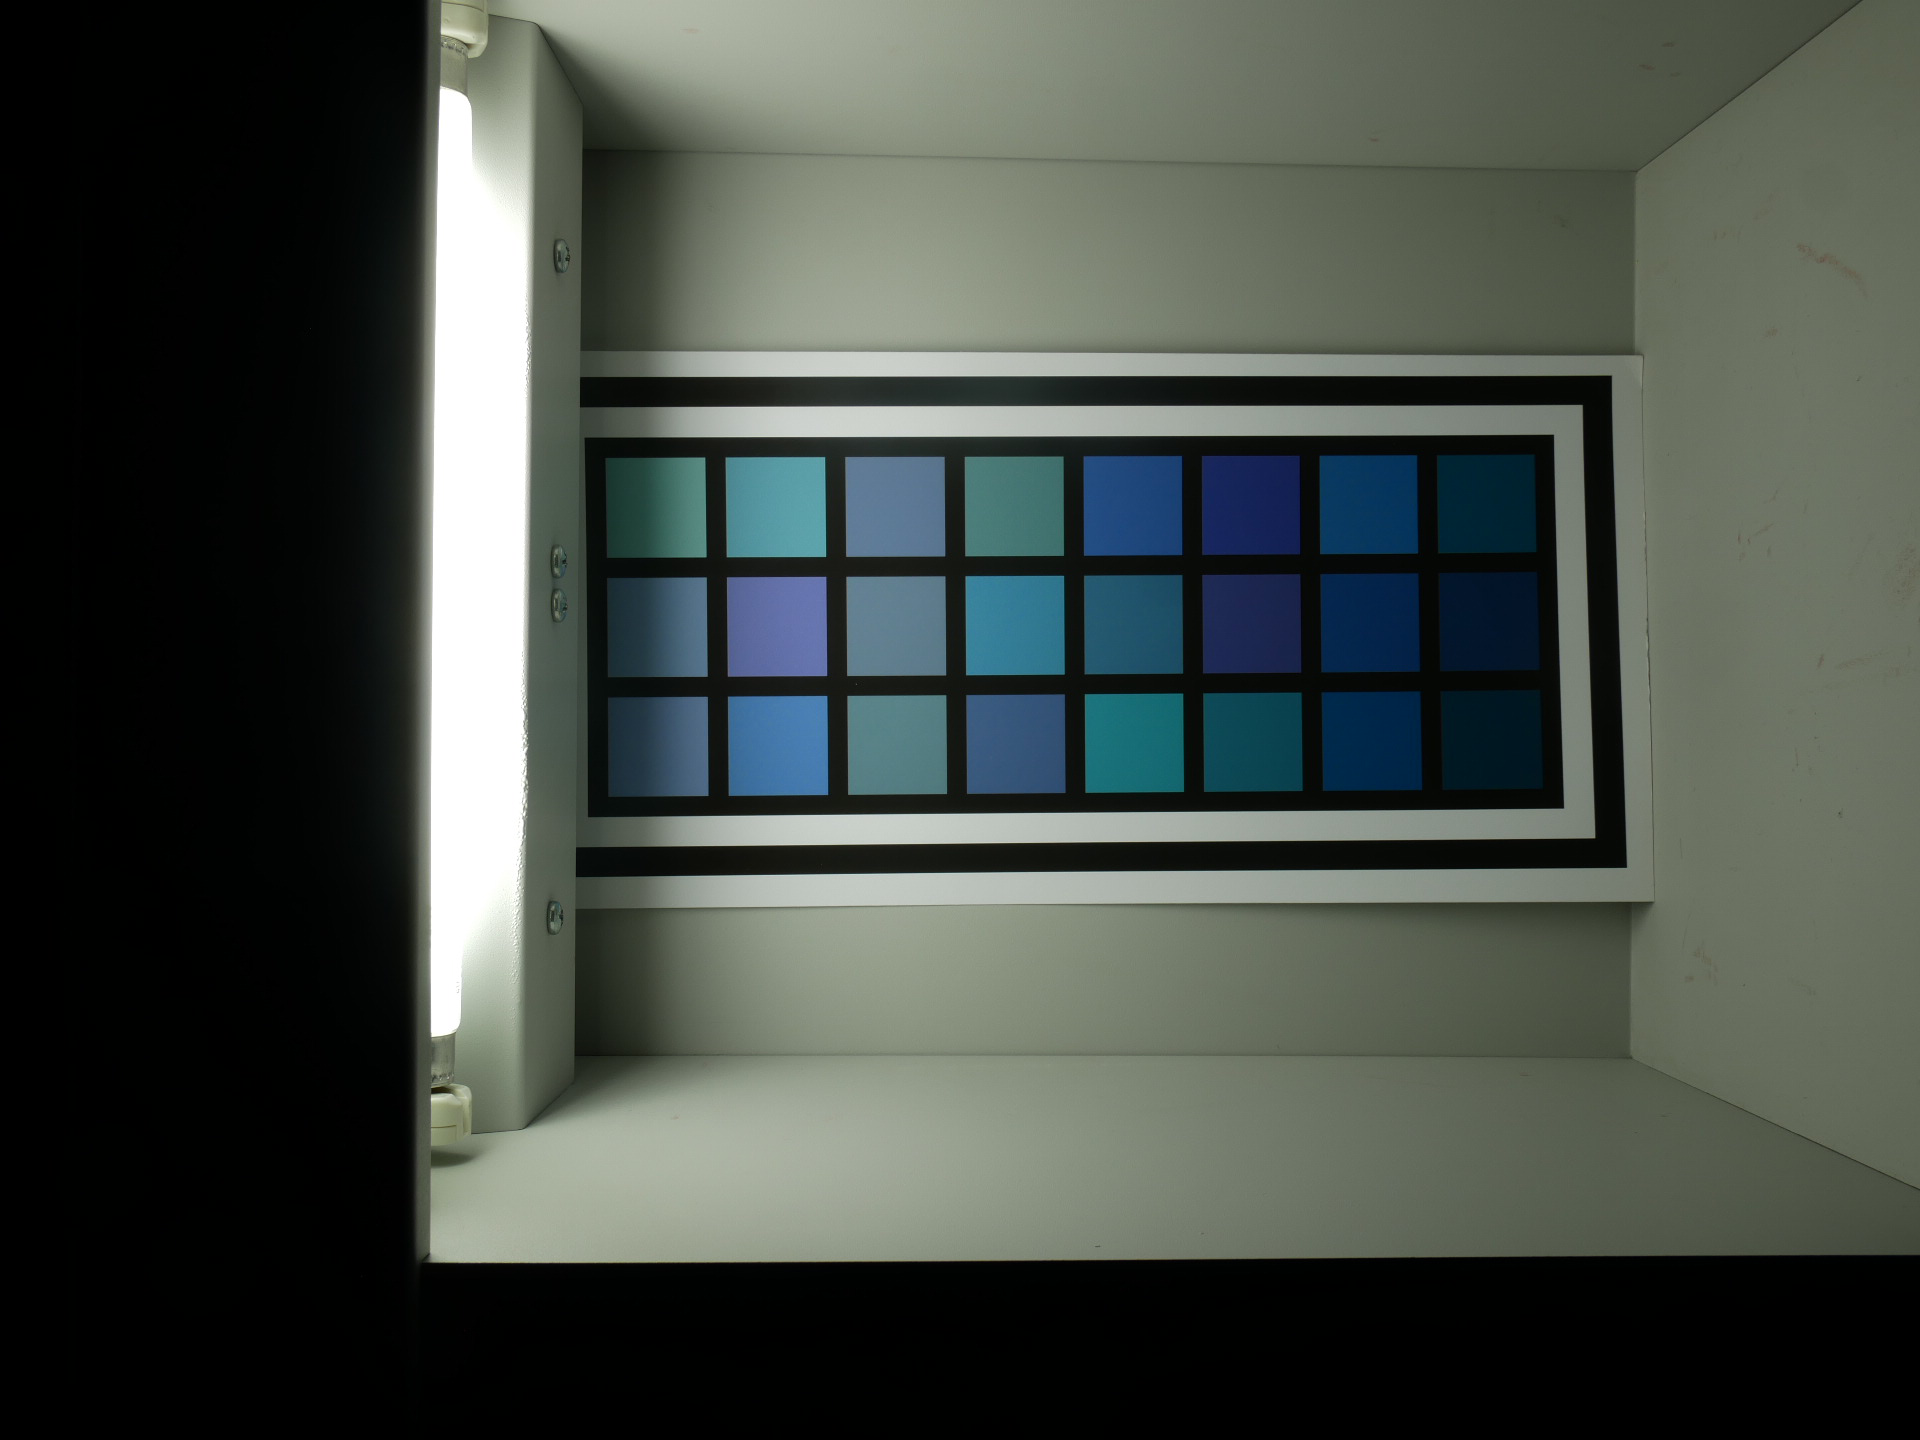

In [2]:
image_path = "data\digital\P1480474.RW2"
raw_image = ""
thumb = ""
processed = ""
raw_colors = ""
with rawpy.imread(image_path) as raw:
    raw_image = raw.raw_image_visible.copy()
    print(f"type: {raw.raw_type}")
    print(f"pattern: {raw.raw_pattern}: {raw.color_desc}")
    thumb = raw.extract_thumb().data
    processed = raw.postprocess()
    raw_colors = raw.raw_colors
    display(Image.open(io.BytesIO(thumb)))
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


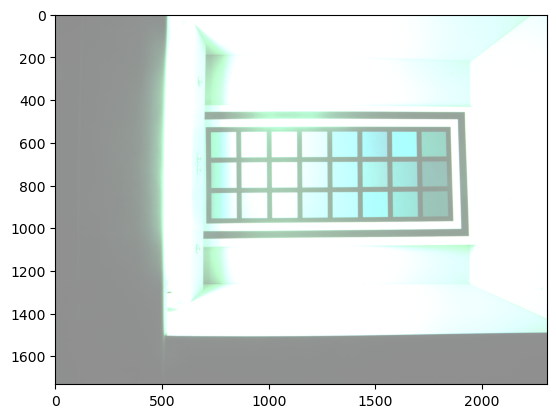

In [3]:
def demosaic(image):
    """
    Converts a raw sensor dump into a 3-tensor of RGB pixel values
    """
    # use every second line, starting at line 0, and every second pixel, starting at pixel 0
    blue = image[::2, ::2]
    # use every second line, starting at line 0, and every second pixel, starting at pixel 1
    green = image[::2, 1::2]
    # use every second line, starting at line 1, and every second pixel, starting at pixel 1
    red = image[1::2, 1::2]
    # stack into a 3-tensor
    return np.dstack((red, green, blue))

demosaiced = demosaic(raw_image)
plt.imshow(demosaiced)


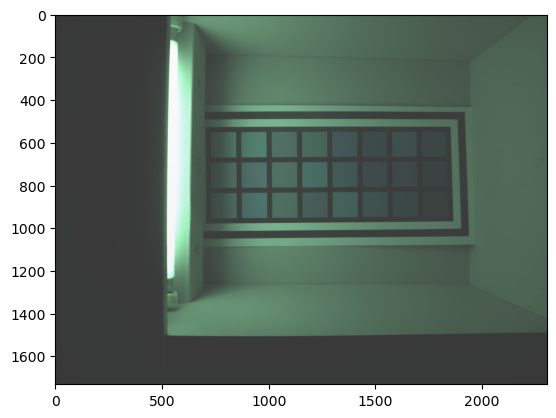

In [4]:
# def invgamma(image, gamma=2.2):
#     """ converts an image of intensities to pixel values,
#     clipping the pixel values to [0,1]"""
#     
#     gamma_corrected = np.power(image, 1/gamma)
#     return np.clip(gamma_corrected, 0, 1)

def invgamma(image, gamma=2):
    """ converts an image of intensities to pixel values,
    clipping the pixel values to [0,1]"""
    lower_bounder = np.maximum(image, 0)
    gamma_corrected = np.power(lower_bounder, 1/gamma)
    return np.minimum(gamma_corrected, 1)

corrected = invgamma(demosaiced/np.max(demosaiced))
plt.imshow(corrected)

In [5]:
import cv2

In [6]:
# test 1: square detection
# Load image, grayscale, and Otsu's threshold
nparr = np.asarray(bytearray(thumb), dtype="uint8")
image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
thresh = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY )[1]

# thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

# Find contours
cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Filter for rectangles and squares
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.04 * peri, True)
    if len(approx) == 4:
        cv2.drawContours(image, [approx], -1, (0, 255, 0), 3)
# Display the image
cv2.imshow('Detected Rectangles and Squares', image)
cv2.waitKey(0)

-1

In [7]:
# test 2: Hough line transform
# Load image, grayscale, Canny edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
# Use HoughLinesP to detect lines
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
# Display the image
cv2.imshow('Hough Lines', image)
cv2.waitKey(0)

-1

In [8]:
from bqplot import pyplot as plt

pl = plt.plot([0, 1, 2], [0, 1, 4], 'o')

pl.on_element_click(lambda self, x: print(x))
plt.show()

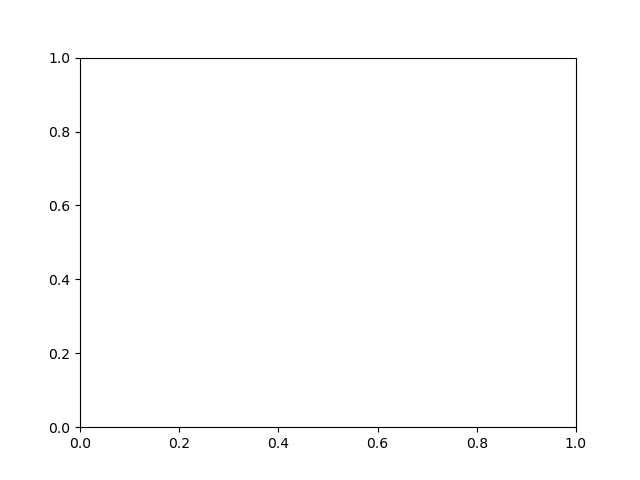

In [9]:
%matplotlib ipympl
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display

fig, ax = plt.subplots()

def onclick(event):
    ix, iy = event.xdata, event.ydata
    display(ix, iy)
    display('done!')

cid = fig.canvas.mpl_connect('button_press_event', onclick)